In [2]:
import os
import json
import sys
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import ALDataModule_v1
from model.AE_model import AECNN1DBNModel, AE1DMaxPoolBNModel
from utils.model_utils import unwrap_model

from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict

In [2]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("-tl", "--train_limit_data", type=int, default=-1,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=6,
                    help=f"Number of class num use to train")

parser.add_argument("-m", "--model_name", type=str,
                    help=f"Config name of model used for training")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=["-m", "4cnnmp_128"])
else:
    args = parser.parse_args()

In [4]:
L.seed_everything(args.random_seed)

Seed set to 42


42

In [8]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = AE1DMaxPoolBNModel(
    **channel_param_dict[args.model_name],).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name           | Type            | Params | In sizes      | Out sizes    
------------------------------------------------------------------------------------
0  | enc_cnn        | Sequential      | 283 K  | [10, 6, 257]  | [10, 256, 1] 
1  | enc_cnn.0      | Conv1d          | 1.8 K  | [10, 6, 257]  | [10, 32, 249]
2  | enc_cnn.1      | MaxPool1d       | 0      | [10, 32, 249] | [10, 32, 83] 
3  | enc_cnn.2      | BatchNorm1d     | 64     | [10, 32, 83]  | [10, 32, 83] 
4  | enc_cnn.3      | ReLU            | 0      | [10, 32, 83]  | [10, 32, 83] 
5  | enc_cnn.4      | Conv1d          | 18.5 K | [10, 32, 83]  | [10, 64, 75] 
6  | enc_cnn.5      | MaxPool1d       | 0      | [10, 64, 75]  | [10, 64, 25] 
7  | enc_cnn.6      | BatchNorm1d     | 128    | [10, 64, 25]  | [10, 64, 25] 
8  | enc_cnn.7      | ReLU            | 0      | [10, 64, 25]  | [10, 64, 25] 
9  | enc_cnn.8      | Conv1d          | 65.7 K | [10, 64, 25]  | [10, 128, 18]
10 | enc_cnn.9      | MaxPool1d       | 0     

In [41]:
n_epochs = 20000
patience = n_epochs//100

batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

log_save_dir = "lightning_logs"
log_save_name =  f"11.1_AE/{args.model_name}-{args.class_num}-{args.train_limit_data}-{args.random_seed}"

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_mse",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_mse", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    devices=4, 
    strategy="ddp"
    )

net = AE1DMaxPoolBNModel(
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    **channel_param_dict[args.model_name],)

data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=batch_size, prefix="torso_", postfix="_fft")
data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)

print("np.unique(data_module.train_label, return_counts=True)", np.unique(data_module.train_label, return_counts=True))

trainer.fit(model=net, datamodule=data_module)
trainer_test_dict = trainer.logged_metrics

trainer.test(model=net, datamodule=data_module)
trainer_test_dict.update(trainer.logged_metrics)

print("trainer.logger.log_dir", trainer.logger.log_dir)

for key in trainer_test_dict.keys():
    trainer_test_dict[key] = trainer_test_dict[key].item()

with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
    json.dump(trainer_test_dict, f, indent=4)

with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

In [9]:
# checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/14_AE_5classes/pattern_27/version_0/checkpoints/sample_epoch=3419-step=68400-val_loss=0.000000.ckpt"

# data_module = FFTDataModule.load_from_checkpoint(checkpoint_path)
# net = AECNN1DModel.load_from_checkpoint(checkpoint_path)

# trainer = L.Trainer()

# trainer.test(model=net, datamodule=data_module)
# output = trainer.predict(model=net, datamodule=data_module)
# pred = torch.argmax(torch.concat(output), dim=1)
# gt = list(map(lambda x: x[0], iter(data_module.predict_dataloader())))
# y = list(map(lambda x: x[1], iter(data_module.predict_dataloader())))

In [10]:
# # %%capture --no-display
# save_image_dir = os.path.join(trainer.logger.log_dir, "compare_img")
# print("save_image_dir", save_image_dir)
# # if os.path.isdir(save_image_dir):
# #     raise ValueError()
    
# os.makedirs(save_image_dir, exist_ok=True)

# for batch in range(len(gt[:1])):
#     for batch_img in range(len(gt[batch][:50])):
#         fig, axs = plt.subplots(6,2, figsize=(10, 12))

#         for i in range(6):
#             axs[i,0].plot(gt[batch][batch_img][i])
#             axs[i,1].plot(pred[batch][batch_img][i])

#         for i in range(2):
#             y_lim_list = max(np.max(gt[batch][batch_img][i*3:(i+1)*3].numpy()), np.max(pred[batch][batch_img][i*3:(i+1)*3].numpy()))
#             for k in range(3):
#                 axs[i*3+k,0].set_ylim([0, y_lim_list])
#                 axs[i*3+k,1].set_ylim([0, y_lim_list])

#         label = y[batch][batch_img]

#         plt.savefig(os.path.join(save_image_dir, f"batch={batch}_{batch_img}_label={label}.png"))
#         # plt.clf()
    

In [21]:
args.eval_mode = 1

if args.eval_mode:
    log_save_dir = "lightning_logs"
    log_save_name = "11.1_AE/{}-{}-{}-{}"
    
    result_save_dict = {}

    for args.model_name in "4cnnmp_128 4cnnmp_64 4cnn_128 4cnn_64 rich_128 rich_64".split(" "):
        args.class_num = 8
        for args.train_limit_data in "1000 5000".split(" "):
            for args.random_seed in "42 64".split():
                
                save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
                save_model_dir = os.path.join(log_save_dir, save_model_folder)
                
                weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                print(save_model_folder, weight)

                net = AE1DMaxPoolBNModel.load_from_checkpoint(weight)
                data_module = ALDataModule_v1.load_from_checkpoint(weight)
                data_module.set_normal_train()

                trainer = L.Trainer()
                trainer.test(model=net, datamodule=data_module, verbose=False)
                
                test_acc = trainer.logged_metrics["test_mse"]
                result_save_dict[save_model_folder] = test_acc


11.1_AE/4cnnmp_128-8-1000-42 lightning_logs/11.1_AE/4cnnmp_128-8-1000-42/version_0/checkpoints/sample_epoch=3009-step=12040-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 118.72it/s]
11.1_AE/4cnnmp_128-8-1000-64 lightning_logs/11.1_AE/4cnnmp_128-8-1000-64/version_0/checkpoints/sample_epoch=2349-step=9400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 114.17it/s]
11.1_AE/4cnnmp_128-8-5000-42 lightning_logs/11.1_AE/4cnnmp_128-8-5000-42/version_0/checkpoints/sample_epoch=1399-step=28000-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 124.67it/s]
11.1_AE/4cnnmp_128-8-5000-64 lightning_logs/11.1_AE/4cnnmp_128-8-5000-64/version_0/checkpoints/sample_epoch=1439-step=28800-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 125.04it/s]
11.1_AE/4cnnmp_64-8-1000-42 lightning_logs/11.1_AE/4cnnmp_64-8-1000-42/version_0/checkpoints/sample_epoch=2099-step=8400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 117.98it/s]
11.1_AE/4cnnmp_64-8-1000-64 lightning_logs/11.1_AE/4cnnmp_64-8-1000-64/version_0/checkpoints/sample_epoch=2039-step=8160-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 106.62it/s]
11.1_AE/4cnnmp_64-8-5000-42 lightning_logs/11.1_AE/4cnnmp_64-8-5000-42/version_0/checkpoints/sample_epoch=959-step=19200-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 97.86it/s]
11.1_AE/4cnnmp_64-8-5000-64 lightning_logs/11.1_AE/4cnnmp_64-8-5000-64/version_0/checkpoints/sample_epoch=1179-step=23600-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 118.47it/s]
11.1_AE/4cnn_128-8-1000-42 lightning_logs/11.1_AE/4cnn_128-8-1000-42/version_0/checkpoints/sample_epoch=2559-step=10240-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 140.75it/s]
11.1_AE/4cnn_128-8-1000-64 lightning_logs/11.1_AE/4cnn_128-8-1000-64/version_0/checkpoints/sample_epoch=1909-step=7640-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 142.45it/s]
11.1_AE/4cnn_128-8-5000-42 lightning_logs/11.1_AE/4cnn_128-8-5000-42/version_0/checkpoints/sample_epoch=2189-step=43800-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 142.47it/s]
11.1_AE/4cnn_128-8-5000-64 lightning_logs/11.1_AE/4cnn_128-8-5000-64/version_0/checkpoints/sample_epoch=3899-step=78000-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 40.75it/s]
11.1_AE/4cnn_64-8-1000-42 lightning_logs/11.1_AE/4cnn_64-8-1000-42/version_0/checkpoints/sample_epoch=1979-step=7920-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 99.72it/s]
11.1_AE/4cnn_64-8-1000-64 lightning_logs/11.1_AE/4cnn_64-8-1000-64/version_0/checkpoints/sample_epoch=2269-step=9080-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 136.02it/s]
11.1_AE/4cnn_64-8-5000-42 lightning_logs/11.1_AE/4cnn_64-8-5000-42/version_0/checkpoints/sample_epoch=1039-step=20800-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 101.72it/s]
11.1_AE/4cnn_64-8-5000-64 lightning_logs/11.1_AE/4cnn_64-8-5000-64/version_0/checkpoints/sample_epoch=1429-step=28600-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 137.91it/s]
11.1_AE/rich_128-8-1000-42 lightning_logs/11.1_AE/rich_128-8-1000-42/version_0/checkpoints/sample_epoch=2379-step=9520-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 45.95it/s]
11.1_AE/rich_128-8-1000-64 lightning_logs/11.1_AE/rich_128-8-1000-64/version_0/checkpoints/sample_epoch=3639-step=14560-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 149.11it/s]
11.1_AE/rich_128-8-5000-42 lightning_logs/11.1_AE/rich_128-8-5000-42/version_0/checkpoints/sample_epoch=3419-step=68400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 151.43it/s]
11.1_AE/rich_128-8-5000-64 lightning_logs/11.1_AE/rich_128-8-5000-64/version_0/checkpoints/sample_epoch=2579-step=51600-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 45.63it/s]
11.1_AE/rich_64-8-1000-42 lightning_logs/11.1_AE/rich_64-8-1000-42/version_0/checkpoints/sample_epoch=3039-step=12160-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 140.91it/s]
11.1_AE/rich_64-8-1000-64 lightning_logs/11.1_AE/rich_64-8-1000-64/version_0/checkpoints/sample_epoch=1889-step=7560-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 140.83it/s]
11.1_AE/rich_64-8-5000-42 lightning_logs/11.1_AE/rich_64-8-5000-42/version_0/checkpoints/sample_epoch=1619-step=32400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 47.92it/s]
11.1_AE/rich_64-8-5000-64 lightning_logs/11.1_AE/rich_64-8-5000-64/version_0/checkpoints/sample_epoch=2149-step=43000-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 97.78it/s]


In [55]:
if args.eval_mode:
    model_name_list = "4cnnmp_128 4cnnmp_64 4cnn_128 4cnn_64 rich_128 rich_64".split(" ")
    args.class_num = 8
    args.train_limit_data = "5000"
    random_list = "42 64".split(" ")
    log_save_name = "11.1_AE/{}-{}-{}-{}"
    
    random_save_dict = {}
    
    for args.random_seed in random_list:
        random_save_dict[args.random_seed] = []
        for args.model_name in model_name_list:
            save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
            random_save_dict[args.random_seed].append(result_save_dict[save_model_folder].item())
    
    print(random_save_dict)

{'42': [0.00046623434172943234, 0.0004839024040848017, 0.00027914170641452074, 0.00038091233000159264, 0.0002826091949827969, 0.0003680587687995285], '64': [0.0004628923488780856, 0.00048300993512384593, 0.00028849561931565404, 0.00036418024683371186, 0.0002759269846137613, 0.00034302944550290704]}


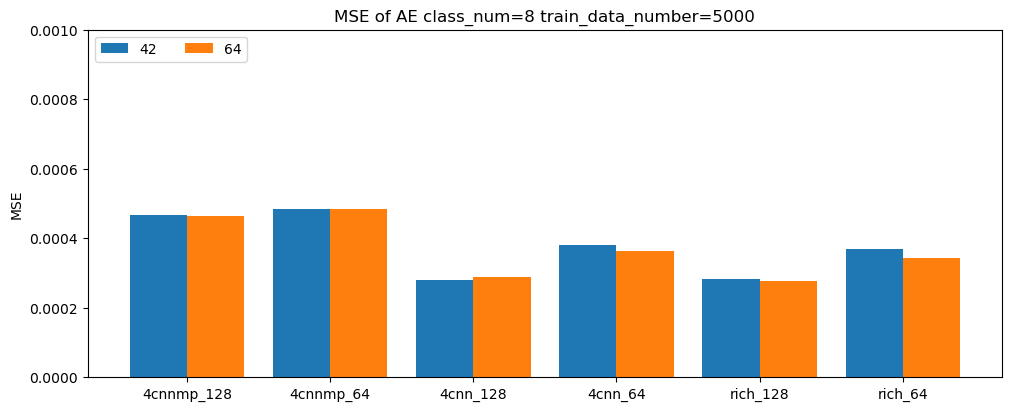

In [56]:
if args.eval_mode:
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 4))
    
    x = np.arange(len(model_name_list))  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0
    
    for attribute, measurement in random_save_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, align="edge")
        # ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('MSE')
    ax.set_title(f'MSE of AE class_num={args.class_num} train_data_number={args.train_limit_data}')
    ax.set_xticks(x + width, model_name_list)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.001)

In [25]:

if args.eval_mode:
    log_save_dir = "lightning_logs"
    log_save_name = "11.1_AE/{}-{}-{}-{}"
    
    output_save_dict = {}

    for args.model_name in "4cnnmp_128 4cnnmp_64 4cnn_128 4cnn_64 rich_128 rich_64".split(" "):
        args.class_num = 8
        for args.train_limit_data in "1000 5000".split(" "):
            for args.random_seed in "42 64".split():
                
                save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
                save_model_dir = os.path.join(log_save_dir, save_model_folder)
                
                weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                print(save_model_folder, weight)

                net = AE1DMaxPoolBNModel.load_from_checkpoint(weight)
                data_module = ALDataModule_v1.load_from_checkpoint(weight)
                data_module.set_normal_train()

                trainer = L.Trainer()
                trainer.test(model=net, datamodule=data_module, verbose=False)
                
                output = trainer.predict(model=net, datamodule=data_module)
                
                pred = torch.concat(output, dim=0)
                gt = list(map(lambda x: x[0], iter(data_module.predict_dataloader())))
                gt_concat = torch.cat(gt, axis=0)

                all_freq_loss = []
                
                for freq_idx in range(257):
                    one_freq_pred = pred[:,:,freq_idx]
                    one_freq_gt = gt_concat[:,:,freq_idx]
                
                    one_freq_loss = F.mse_loss(one_freq_pred, one_freq_gt)
                    all_freq_loss.append(one_freq_loss)

                output_save_dict[save_model_folder] = all_freq_loss


11.1_AE/4cnnmp_128-8-1000-42 lightning_logs/11.1_AE/4cnnmp_128-8-1000-42/version_0/checkpoints/sample_epoch=3009-step=12040-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 130.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 95.42it/s]
11.1_AE/4cnnmp_128-8-1000-64 lightning_logs/11.1_AE/4cnnmp_128-8-1000-64/version_0/checkpoints/sample_epoch=2349-step=9400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 129.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 107.21it/s]
11.1_AE/4cnnmp_128-8-5000-42 lightning_logs/11.1_AE/4cnnmp_128-8-5000-42/version_0/checkpoints/sample_epoch=1399-step=28000-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 114.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 89.30it/s]
11.1_AE/4cnnmp_128-8-5000-64 lightning_logs/11.1_AE/4cnnmp_128-8-5000-64/version_0/checkpoints/sample_epoch=1439-step=28800-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 117.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 111.40it/s]
11.1_AE/4cnnmp_64-8-1000-42 lightning_logs/11.1_AE/4cnnmp_64-8-1000-42/version_0/checkpoints/sample_epoch=2099-step=8400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 122.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 88.62it/s]
11.1_AE/4cnnmp_64-8-1000-64 lightning_logs/11.1_AE/4cnnmp_64-8-1000-64/version_0/checkpoints/sample_epoch=2039-step=8160-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 88.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 113.25it/s]
11.1_AE/4cnnmp_64-8-5000-42 lightning_logs/11.1_AE/4cnnmp_64-8-5000-42/version_0/checkpoints/sample_epoch=959-step=19200-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 92.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 112.35it/s]
11.1_AE/4cnnmp_64-8-5000-64 lightning_logs/11.1_AE/4cnnmp_64-8-5000-64/version_0/checkpoints/sample_epoch=1179-step=23600-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 89.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 91.29it/s]
11.1_AE/4cnn_128-8-1000-42 lightning_logs/11.1_AE/4cnn_128-8-1000-42/version_0/checkpoints/sample_epoch=2559-step=10240-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 101.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 115.72it/s]
11.1_AE/4cnn_128-8-1000-64 lightning_logs/11.1_AE/4cnn_128-8-1000-64/version_0/checkpoints/sample_epoch=1909-step=7640-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 102.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 107.10it/s]
11.1_AE/4cnn_128-8-5000-42 lightning_logs/11.1_AE/4cnn_128-8-5000-42/version_0/checkpoints/sample_epoch=2189-step=43800-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 102.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 103.98it/s]
11.1_AE/4cnn_128-8-5000-64 lightning_logs/11.1_AE/4cnn_128-8-5000-64/version_0/checkpoints/sample_epoch=3899-step=78000-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 108.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 87.87it/s]
11.1_AE/4cnn_64-8-1000-42 lightning_logs/11.1_AE/4cnn_64-8-1000-42/version_0/checkpoints/sample_epoch=1979-step=7920-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 96.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 96.64it/s]
11.1_AE/4cnn_64-8-1000-64 lightning_logs/11.1_AE/4cnn_64-8-1000-64/version_0/checkpoints/sample_epoch=2269-step=9080-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 103.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 100.42it/s]
11.1_AE/4cnn_64-8-5000-42 lightning_logs/11.1_AE/4cnn_64-8-5000-42/version_0/checkpoints/sample_epoch=1039-step=20800-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 111.32it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 110.33it/s]
11.1_AE/4cnn_64-8-5000-64 lightning_logs/11.1_AE/4cnn_64-8-5000-64/version_0/checkpoints/sample_epoch=1429-step=28600-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 87.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 95.75it/s]
11.1_AE/rich_128-8-1000-42 lightning_logs/11.1_AE/rich_128-8-1000-42/version_0/checkpoints/sample_epoch=2379-step=9520-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 108.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████| 16/16 [00:00<00:00, 94.04it/s]
11.1_AE/rich_128-8-1000-64 lightning_logs/11.1_AE/rich_128-8-1000-64/version_0/checkpoints/sample_epoch=3639-step=14560-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 112.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 108.95it/s]
11.1_AE/rich_128-8-5000-42 lightning_logs/11.1_AE/rich_128-8-5000-42/version_0/checkpoints/sample_epoch=3419-step=68400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 141.68it/s]
11.1_AE/rich_128-8-5000-64 lightning_logs/11.1_AE/rich_128-8-5000-64/version_0/checkpoints/sample_epoch=2579-step=51600-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 101.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 107.65it/s]
11.1_AE/rich_64-8-1000-42 lightning_logs/11.1_AE/rich_64-8-1000-42/version_0/checkpoints/sample_epoch=3039-step=12160-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 96.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 104.73it/s]
11.1_AE/rich_64-8-1000-64 lightning_logs/11.1_AE/rich_64-8-1000-64/version_0/checkpoints/sample_epoch=1889-step=7560-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 113.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 116.51it/s]
11.1_AE/rich_64-8-5000-42 lightning_logs/11.1_AE/rich_64-8-5000-42/version_0/checkpoints/sample_epoch=1619-step=32400-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 121.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 119.34it/s]
11.1_AE/rich_64-8-5000-64 lightning_logs/11.1_AE/rich_64-8-5000-64/version_0/checkpoints/sample_epoch=2149-step=43000-val_loss=0.000000.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 106.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|███████████████████████████| 16/16 [00:00<00:00, 129.55it/s]


In [49]:
def plot_freq(freq_loss_list, axs, color=None, label=None, title=None):
    axs.bar(range(257), freq_loss_list, width=1, align="edge", alpha=0.7, color=color, label=label)
    axs.set_xlabel("Frequence")
    axs.set_ylabel("MSE")
    if not title:
        axs.set_title("MSE Loss for each frequence")
    else:
        axs.set_title(f"{title} MSE Loss for each frequence")

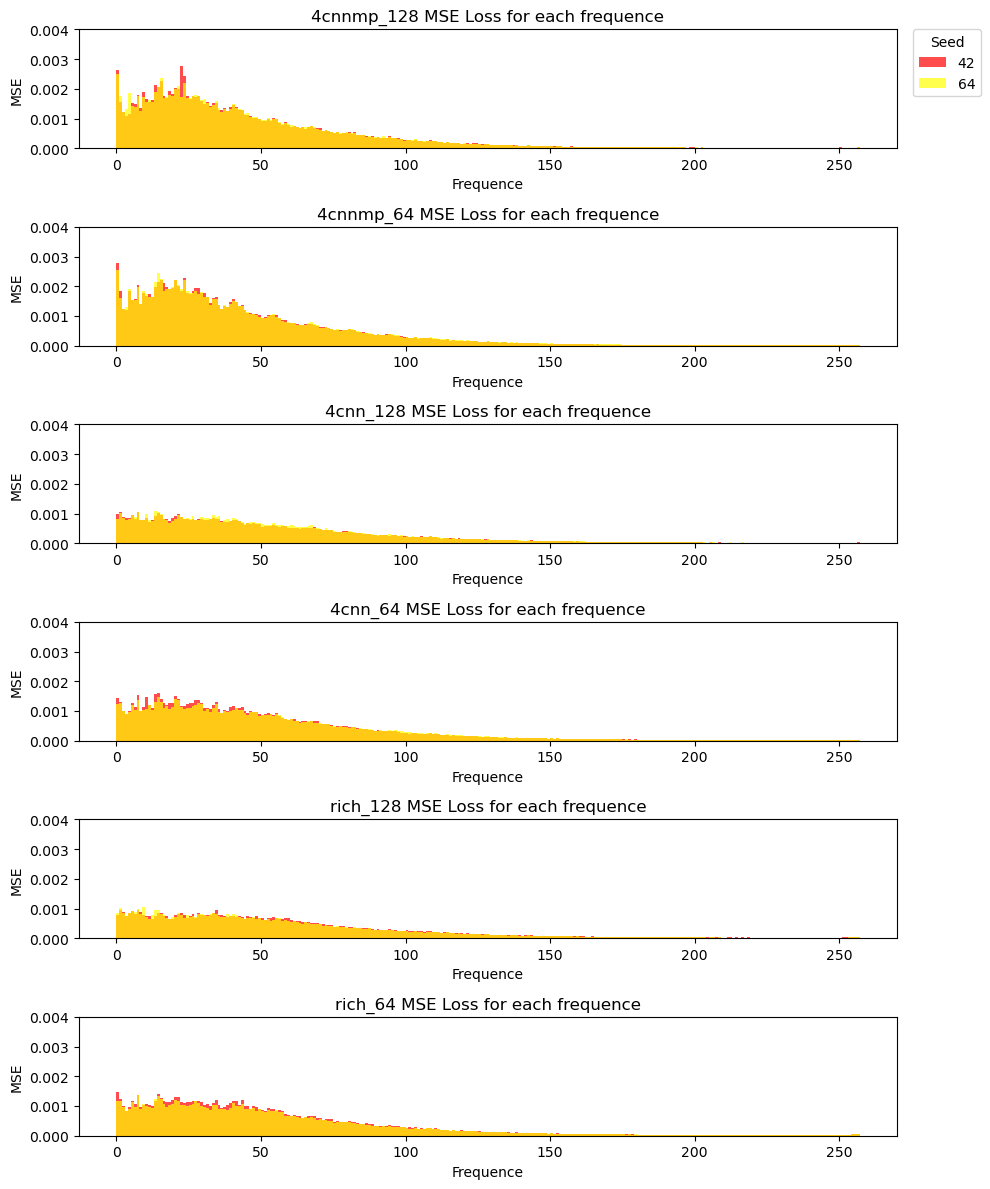

In [59]:
if args.eval_mode:
    model_name_list = "4cnnmp_128 4cnnmp_64 4cnn_128 4cnn_64 rich_128 rich_64".split(" ")
    args.class_num = 8
    args.train_limit_data = "5000"
    random_list = "42 64".split(" ")
    log_save_name = "11.1_AE/{}-{}-{}-{}"
    color_list = ["red", "yellow"]
    
    fig, axs = plt.subplots(len(model_name_list), figsize=(10, 12))
    for i, args.model_name in enumerate(model_name_list):
        for args.random_seed, color in zip(random_list, color_list):
            save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
            freq_loss_list = output_save_dict[save_model_folder]

            plot_freq(freq_loss_list, axs[i], color=color, label=f"{args.random_seed}", title=args.model_name)
            axs[i].set_ylim([0, 0.004])

    axs[0].legend(title="Seed", loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)

    plt.tight_layout()


In [68]:
if args.eval_mode:
    AE_name = "rich_64"
    net = AE1DMaxPoolBNModel(
        **channel_param_dict[AE_name],
    )
    print(f"AE: {AE_name}")
    print(net)

AE: rich_64
AE1DMaxPoolBNModel(
  (enc_cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(8,), stride=(3,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc_linear): Sequential(
    (0): Linear(in_features=1664, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (dec_linear): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Sequential(
      (0): Linear(in_features=256, ou